In [ ]:
import os, copy, pickle, torch, torchvision, types
import types
from torch import Tensor
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split

import numpy as np
from tqdm import tqdm

from utils import AverageMeter, accuracy, save_checkpoint, plot_train_progress
from loss import LossComputer

from data.dro_dataset import get_loader

In [ ]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
class FeatResNet(nn.Module):
    
    def __init__(self, core_resnet, level):
        super(FeatResNet, self).__init__()
        self.internal = core_resnet
        self.level = level
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.internal.conv1(x)
        x = self.internal.bn1(x)
        x = self.internal.relu(x)
        x = self.internal.maxpool(x)

        x = self.internal.layer1(x)
        if self.level == 1: return x
        
        x = self.internal.layer2(x)
        if self.level == 2: return x
        
        x = self.internal.layer3(x)
        if self.level == 3: return x
        
        x = self.internal.layer4(x)
        if self.level == 4: return x

        x = self.internal.avgpool(x)
        x = torch.flatten(x, 1)
        ft = x
        x = self.internal.fc(x)

        return x

class Projector(nn.Module):
    def __init__(self, d):
        super(Projector, self).__init__()
        self.fc = nn.Linear(d, 2)

    def forward(self, x):
        x = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(x), 1)
        x = self.fc(x)
        return x

In [ ]:
# train
def train(model, projector, optimizer, train_loader, num_epochs=8):
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    model.eval()
    projector.train()
    for epoch in range(num_epochs):
#         print(epoch)
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device='cuda')
            y = batch[1].to(device='cuda')
            yhat = projector(model(x))
            loss = criterion(yhat, y).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def infer(model, projector, test_loader, widx=2):
    model.eval()
    projector.eval()
    
    pred_probs_list = []
    correct_pred_list = []
    worst_collect_list = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            x = batch[0].to(device='cuda')
            y = batch[1]
            g = batch[2]
            yhat = torch.softmax(projector(model(x)), dim=1).to(device='cpu')
            top_preds = torch.argmax(yhat, dim=1)
            correct = top_preds == y
            worst_flag = g == widx
            
            pred_probs_list.append(yhat)
            correct_pred_list.append(correct)
            worst_collect_list.append(worst_flag)
    
    pred_probs = torch.cat(pred_probs_list, dim=0)
    correct_preds = torch.cat(correct_pred_list, dim=0)
    worst_collect = torch.cat(worst_collect_list, dim=0)
    return pred_probs, correct_preds, worst_collect

In [13]:
def get_margin_hist(dataset, epoch, feature_level):
    
    if dataset == 'CelebA': 
        learning_rate = 1e-4
        widx = 3
        epochs = 1
        pkl_name = 'Blond_Hair_Male_dataset_0.pkl'
    else: # could be named waterbirds
        dataset = 'CUB'
        learning_rate = 1e-3
        widx = 2
        epochs = 0 # change
        pkl_name = 'waterbird_complete95_forest2water2_dataset_0.pkl'
    
    loader_kwargs = {'batch_size':10, 'num_workers':4, 'pin_memory':True}
    with open(os.path.join('results', dataset, pkl_name), 'rb') as file:
        data = pickle.load(file)
        train_data = data['train_data']
        train_loader = get_loader(train_data, train=True, **loader_kwargs)
    loader_kwargs = {'batch_size':128, 'num_workers':4, 'pin_memory':True}
    n = len(train_data)
    train_data, test_data = random_split(train_data, [n//2, n-n//2])
    train_loader, test_loader = get_loader(train_data, train=True, **loader_kwargs), get_loader(test_data, train=False, **loader_kwargs)
    
    model = torchvision.models.resnet18().to(device='cuda')
    d = model.fc.in_features
    model.fc = nn.Linear(d, 2).to(device='cuda')
    model_ckpt = torch.load(os.path.join(f'./results/{dataset}/resnet18-pt_0/', f'{epoch}_ckpt.pth.tar'))
    model.load_state_dict(model_ckpt['model'])
    model.eval()
    model = FeatResNet(model, feature_level)
    samples = next(iter(train_loader))
    sample_inputs = samples[0].to(device='cuda')
    features = model(sample_inputs)
    d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
    projector = Projector(d).to(device='cuda')
    projector.train()
    
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, projector.parameters()), 
                                lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    train(model, projector, optimizer, train_loader, num_epochs=epochs)

    yhat, correct, worst = infer(model, projector, test_loader, widx=widx)
    confident = torch.abs(yhat[:, 0] - yhat[:, 1])
    
    num_bins = 20

    # Separate rows based on conditions
    rows_tt = (correct == True) & (worst == True)
    rows_tf = (correct == True) & (worst == False)
    rows_ff = (correct == False) & (worst == False)
    rows_ft = (correct == False) & (worst == True)

    # Create histograms for each group of rows based on the value of confident
    hist_tt, edges_tt = np.histogram(confident[rows_tt], bins=num_bins, range=(0, 1))
    hist_tf, edges_tf = np.histogram(confident[rows_tf], bins=num_bins, range=(0, 1))
    hist_ff, edges_ff = np.histogram(confident[rows_ff], bins=num_bins, range=(0, 1))
    hist_ft, edges_ft = np.histogram(confident[rows_ft], bins=num_bins, range=(0, 1))

    # Create a 1x4 subplot for the four histograms
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Plot the histograms
    axs[0].hist(confident[rows_tt], bins=edges_tt, color='blue', alpha=0.7)
    axs[0].set_title('Pred=right, worst=yes')
    axs[1].hist(confident[rows_tf], bins=edges_tf, color='green', alpha=0.7)
    axs[1].set_title('Pred=right, worst=no')
    axs[2].hist(confident[rows_ff], bins=edges_ff, color='red', alpha=0.7)
    axs[2].set_title('Pred=wrong, worst=no')
    axs[3].hist(confident[rows_ft], bins=edges_ft, color='purple', alpha=0.7)
    axs[3].set_title('Pred=wrong, worst=yes')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


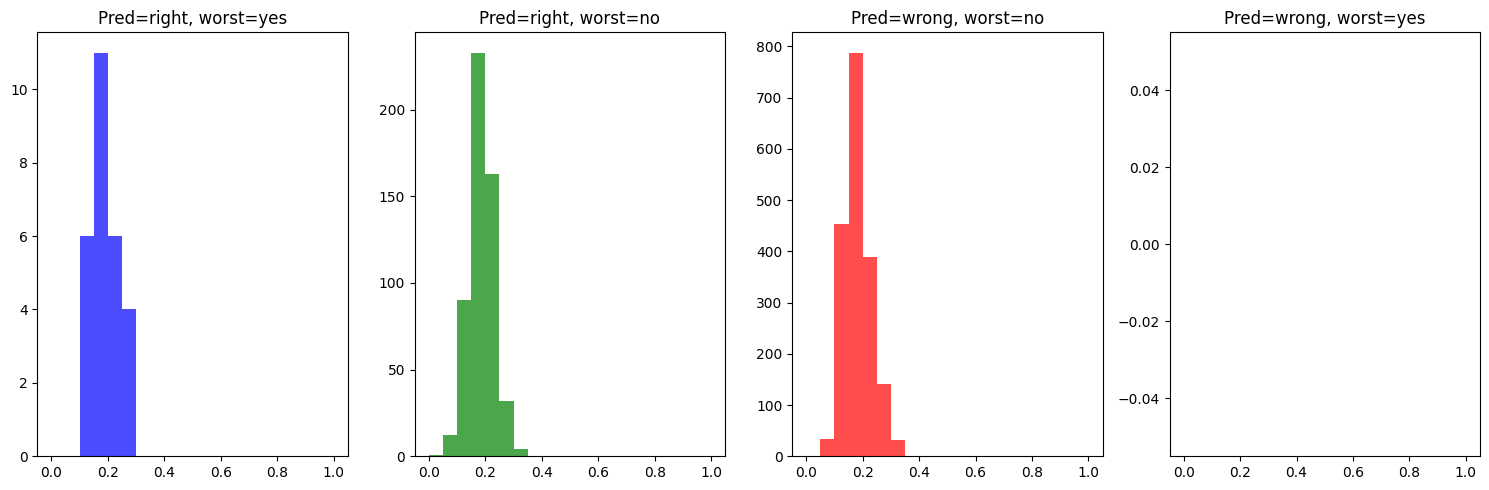

In [14]:
get_margin_hist('CUB', 60, 1)

In [ ]:
get_margin_hist('CelebA', 60, 1)

In [ ]:
get_margin_hist(60, 1)

In [ ]:
get_margin_hist(60, 2)

In [ ]:
get_margin_hist(60, 3)

In [ ]:
get_margin_hist(60, 4)

In [ ]:
get_margin_hist(30, 1)

In [ ]:
get_margin_hist(147, 2)

In [ ]:
def calculate_tpr_fpr(output, target):
    tp = torch.sum(output & target).item()
    fp = torch.sum(output & ~target).item()
    fn = torch.sum(~output & target).item()
    tn = torch.sum(~output & ~target).item()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    return tpr, fpr, acc

def get_stats(epoch, feature_level, threshold=0.4):

    model = torchvision.models.resnet18().to(device='cuda')
    d = model.fc.in_features
    model.fc = nn.Linear(d, 2).to(device='cuda')
    model_ckpt = torch.load(os.path.join('./results/CUB/resnet18-pt_0/', f'{epoch}_ckpt.pth.tar'))
    model.load_state_dict(model_ckpt['model'])
    model.eval()
    model = FeatResNet(model, feature_level)
    
    samples = next(iter(train_loader))
    sample_inputs = samples[0].to(device='cuda')
    features = model(sample_inputs)
    d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
    projector = Projector(d).to(device='cuda')
    projector.train()
    
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, projector.parameters()), 
                                lr=3e-4, momentum=0.9, weight_decay=5e-4)
    
    train(model, projector, optimizer, train_loader, num_epochs=8)
    yhat, correct, worst = infer(model, projector, test_loader)
    
    confident = torch.abs(yhat[:, 0] - yhat[:, 1]) > threshold
    worst_group_preds = (correct & False) | (~correct & confident)
    return calculate_tpr_fpr(worst_group_preds, worst)
    
def plot_tpr_fpr(feature_level, threshold=0.4, num_epochs=10):
    tprs, fprs, accs = [], [], []
    epoch_list = [3*x for x in range(num_epochs)]
    for x in tqdm(range(num_epochs)):
        epoch = x*3
        tpr, fpr, acc = get_stats(epoch, feature_level, threshold)
        tprs.append(tpr)
        fprs.append(fpr)
        accs.append(acc)
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    ax[0].plot(epoch_list, tprs)
    ax[0].set_title("TPR")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("TPR")
    
    ax[1].plot(epoch_list, fprs)
    ax[1].set_title("FPR")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("FPR")

    ax[2].plot(epoch_list, accs)
    ax[2].set_title("Accuracy")
    ax[2].set_xlabel("epoch")
    ax[2].set_ylabel("Acc")
    
    plt.tight_layout()
    plt.show()
    
    
    

In [ ]:
plot_tpr_fpr(3, 0.6, 20)

In [ ]:
plot_tpr_fpr(4, 0.6, 20)

In [ ]:
plot_tpr_fpr(2, 0.6, 40)